In [1]:
from CommonTools.dbapi import ScotiaDB2, MySQL, dbIO
from CommonTools.login import get_credential
from CommonTools.settings import SETTINGS
from CommonTools.utils import df_strip
from CommonTools.sparker import SparkConnector
from CommonTools.remote import MyRemote

import pandas as pd
import numpy as np
import logging

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)
SETTINGS.SET_CREDENTIAL_INTERACTIVE()  # set to interactive mode

## Preparation for data connection

In [2]:
username, PASSWORD = get_credential()

Your SID:  ········
Your password:  ·············


In [3]:
db2_conf = ScotiaDB2(db = "DM1P1D")
db2_conf.login(username, PASSWORD)

In [4]:
mysql_conf = MySQL() # initiate a MySQL connector
mysql_conf.bindServer(ip = "10.58.57.24", port = 3306, db = "weekly_sales") # this is a database installed on my VDI and stores sales data
mysql_conf.login(username, PASSWORD)  # login to the database using your SID and password

In [5]:
# connect to iw607 is pretty straight forward, as it only need ip, port, username and password
ip_iw607, port = "10.56.70.52", 22
iw607 = MyRemote(ip_iw607, port, username, PASSWORD)

In [24]:
# download EDL data for spark EDA demo (part3)

# create a sql file containing query to EDL
!echo "select from_unixtime(unix_timestamp(cast(datekey as string), 'yyyymmdd'), 'yyyy-mm-dd') as dt, productkey, average_balance as avg_bal from caz_cbf.dbo_fact_data_cust_acct where system_code  = 'GIC' and datekey = 20210731" > "/home/jovyan/work/edl-test-query.sql"  # no semicolon(;) at end of query!! 

# use Hive query instead
! $CONNECTOR_JDBC_HOME/edldump \
        -e '/home/jovyan/edl_hive.yml' \
        -f Default \
        -i '/home/jovyan/work/edl-test-query.sql' \
        -o '/home/jovyan/work/edl-ftp.csv'

log4j:WARN No appenders could be found for logger (org.apache.hadoop.metrics2.lib.MutableMetricsFactory).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
16:22:16.758 DEBUG o.a.hadoop.util.PerformanceAdvisory - Falling back to shell based
16:22:16.808 INFO  c.s.dsa.jdbc.TenXHiveConnector - setting Hadoop UserGroupInformation to user "s1460341@SCGLOBAL.AD.SCOTIACAPITAL.COM" with keytab "/home/jovyan/.keytabs/edl.keytab"
16:22:16.918 INFO  c.s.dsa.jdbc.Jdbc2CsvExporter - Validation OK. Creating connection...
16:22:16.918 INFO  c.s.dsa.jdbc.TenXHiveConnector - JDBC connection driver: org.apache.hive.jdbc.HiveDriver
16:22:16.918 INFO  c.s.dsa.jdbc.TenXHiveConnector - JDBC connection url: jdbc:hive2://sdpsvrwm0128.scglobal.ad.scotiacapital.com:10000/default;principal=hive/_HOST@SCGLOBAL.AD.SCOTIACAPITAL.COM
16:22:16.918 INFO  c.s.dsa.jdbc.TenXHiveConnector - JDBC connection user: hive
16:22:34.387 IN

## Part 1. EDA for table/query in database

#### eg1.EDA on entire table from EDW

In [6]:
from ModelingTools.Explore.preview import DbPreviewer

# you can do EDA on the entire table:
dbp = DbPreviewer(db2_conf, tb = "EDRDS.GIC_PRC_OFR_S")  # look at table GIC_PRC_OFR_S from DB2

/opt/conda/lib/python3.8/site-packages/sqlalchemy/engine/default.py:393: SAWarning: Exception attempting to detect unicode returns: ProgrammingError('(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: SQLNumResultCols failed: [IBM][CLI Driver][DB2/AIX64] SQL1216N  Graphic data and graphic functions are not supported for this database.  SQLSTATE=56031 SQLCODE=-1216')
  util.warn(


CategCol([total/missing/rate] = [11341239/0/0.0%], categ lvls = 5)


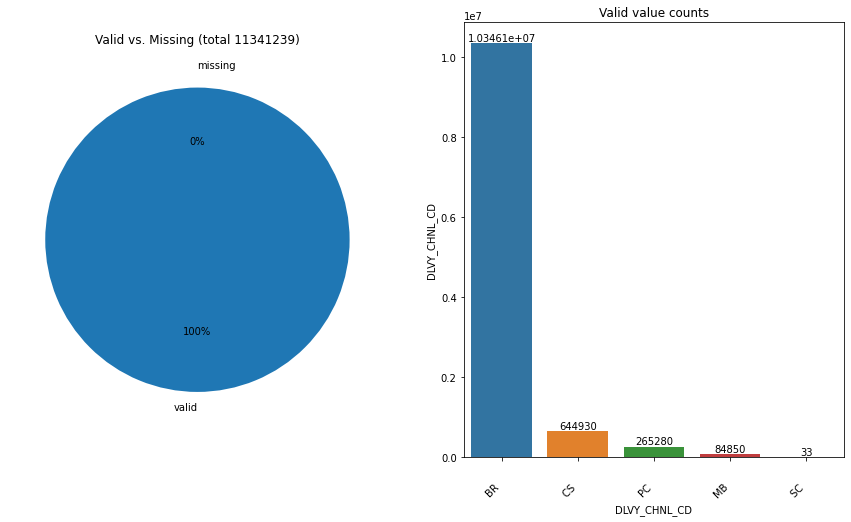

In [7]:
print(dbp.view_categ("DLVY_CHNL_CD")) # look at categorical var - DLVY_CHNL_CD

NumCol([total/missing/rate] = [11341239/0/0.0%], normal_boundary = [-63832.360000000015, 127720.60000000002])
count    1.134124e+07
mean     8.491360e+04
std      7.186768e+05
min      0.000000e+00
25%      8.000000e+03
50%      1.950214e+04
75%      5.588824e+04
max      1.000000e+09
Name: ISSU_AMT, dtype: float64


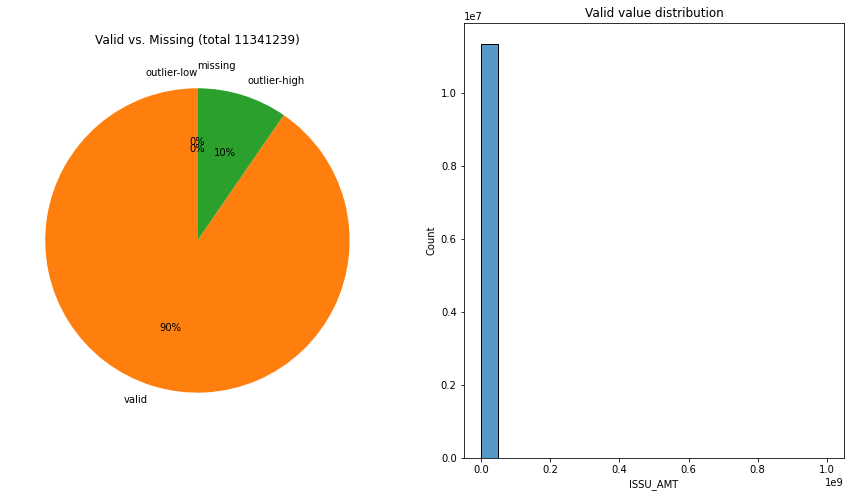

In [8]:
print(dbp.view_numeric("ISSU_AMT", bins = 50)) # look at numerical var - issue amount

#### eg2.EDA on partial and transformed table from EDW

In [9]:
from ModelingTools.Explore.preview import DbPreviewer

# you can do EDA on the partial table by specifying the SQL query:
sql = """
select 
    HML_SEGMENT, 
    FTP, 
    case 
        when BK_BAL_CAD_EQV > 0 then log10(BK_BAL_CAD_EQV)
        else null
    end as LOG_BK -- log10 of book value, as it will follow normal distribution
from 
    DSSGIC.GIC_WEEKLY_SALES_TEST 
where 
    GIC_ORG_DT between '2022-08-01' and '2022-08-31'
"""
dbp = DbPreviewer(db2_conf, sql = sql, view_schema = 'DSSGIC')

/opt/conda/lib/python3.8/site-packages/sqlalchemy/engine/default.py:393: SAWarning: Exception attempting to detect unicode returns: ProgrammingError('(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: SQLNumResultCols failed: [IBM][CLI Driver][DB2/AIX64] SQL1216N  Graphic data and graphic functions are not supported for this database.  SQLSTATE=56031 SQLCODE=-1216')
  util.warn(


CategCol([total/missing/rate] = [100354/36599/36.5%], categ lvls = 4)


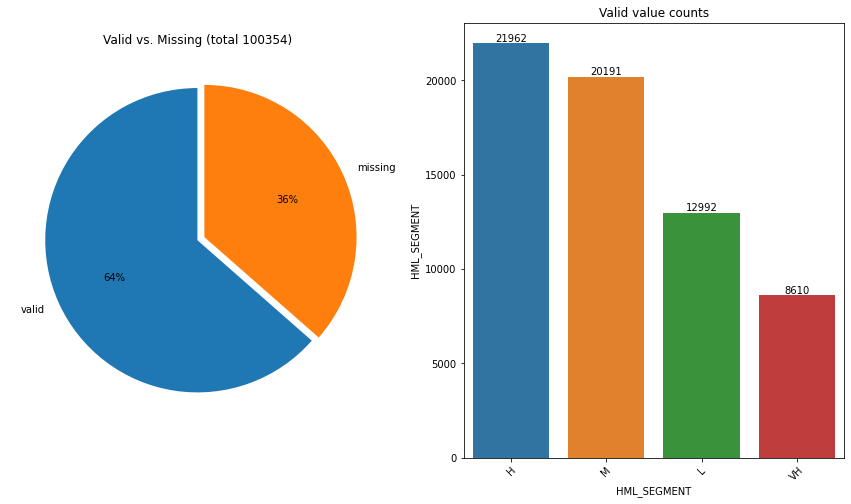

In [10]:
print(dbp.view_categ("HML_SEGMENT"))

NumCol([total/missing/rate] = [100354/24474/24.4%], normal_boundary = [nan, nan])
count    75880.000000
mean         4.797383
std          0.356330
min          2.883600
25%          4.636300
50%          4.872600
75%          5.071200
max          5.250600
Name: FTP, dtype: float64


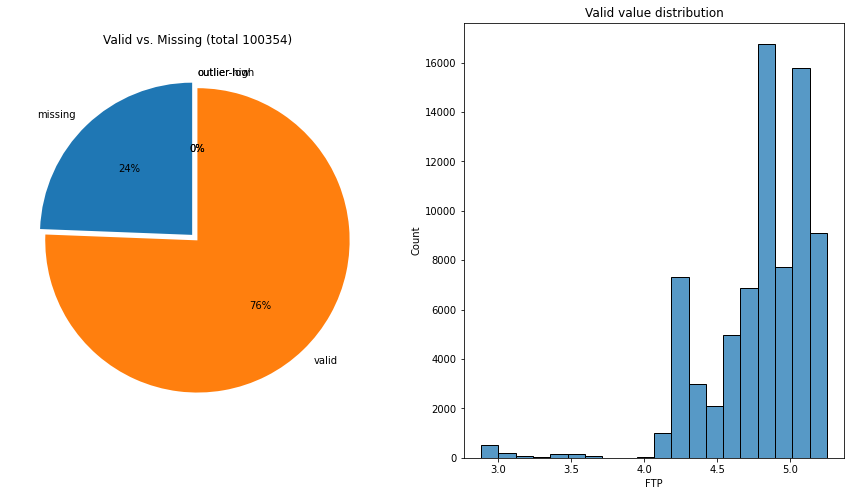

In [11]:
print(dbp.view_numeric("FTP"))

NumCol([total/missing/rate] = [100354/102/0.1%], normal_boundary = [nan, nan])
count    100252.000000
mean          4.233076
std           0.630918
min          -2.000000
25%           3.903090
50%           4.173013
75%           4.698970
max           7.466553
Name: LOG_BK, dtype: float64


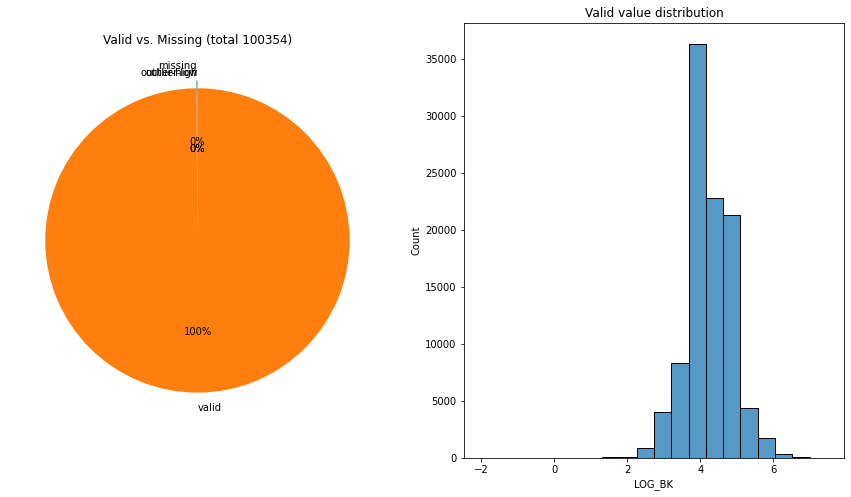

In [12]:
print(dbp.view_numeric("LOG_BK"))  # EDA on transformed column

#### eg3. EDA for data from database (MySQL)

In [13]:
from ModelingTools.Explore.preview import DbPreviewer

dbp = DbPreviewer(mysql_conf, tb = "weekly_sales.aq_df_raw")  # look at table GIC_PRC_OFR_S from DB2

CategCol([total/missing/rate] = [2193339/0/0.0%], categ lvls = 44)


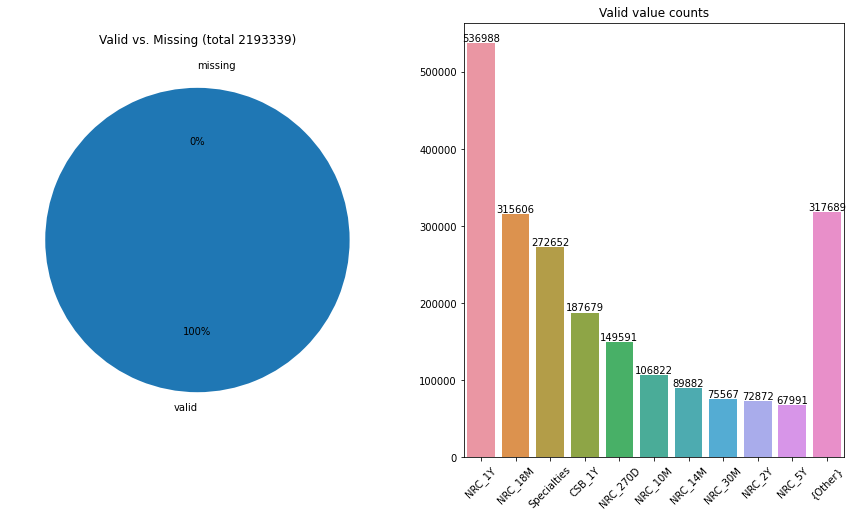

In [14]:
print(dbp.view_categ("GIC_PRD3"))  # all the minor bins will be auto combined to`Other` categ

NumCol([total/missing/rate] = [2193339/383294/17.5%], normal_boundary = [nan, nan])
count    1.810045e+06
mean     2.479165e-03
std      9.661804e-02
min     -2.730000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.680000e+00
Name: BK_OVER_BDL, dtype: float64


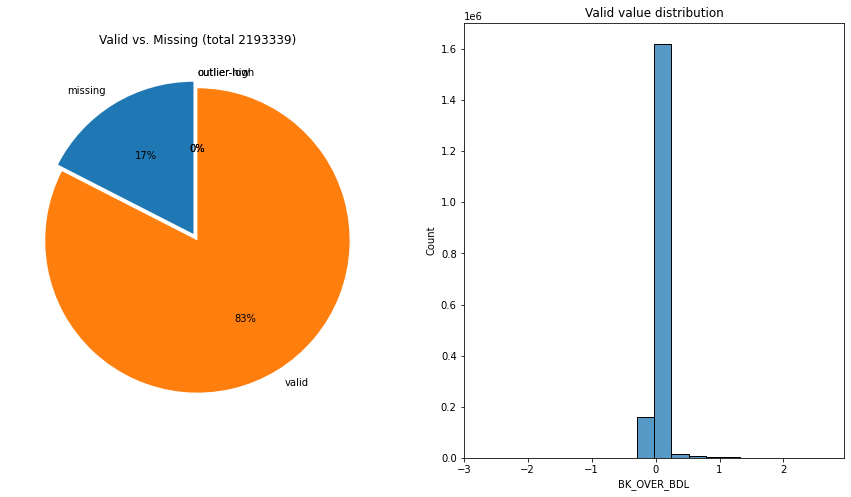

In [15]:
print(dbp.view_numeric("BK_OVER_BDL"))

## Part2. EDA for pandas dataframe

In [16]:
with iw607.getFileHandler("/rcca/ProdEcon/AQ/LargeDataSets/AQ_PRC_CALL_SB_202201_202203.parquet", mode = "r") as obj:
    df = pd.read_parquet(obj)
df['LOG_ISSU_AMT'] = np.log10(df['ISSU_AMT'])  # log transform
df 

CID                                  MSTR_KEY  \
0      020011145339438  LTNRC2A12X11XXX86XXXXXZZZZZ000             
1      002093151610567  LTNRC2A12X11XXX80XXXXXZZZZZ001             
2      995060000215224  CASHC2A12X21XXX83XXXXXZZZZZ000             
3      013296092339757  LTNRC2A12X11XXX86XXXXXZZZZZ000             
4      016076142331602  LTNRU8A12X78XXX88XXXXXZZZZZ001             
...                ...                                       ...   
22129  995010000097760  LTNRC2A12X11XXX83XXXXXZZZZZ001             
22130  098202153853329  CASHC2A12X21XXX83XXXXXZZZZZ000             
22131  995080000543507  CASHC2A12X31XXX83XXXXXZZZZZ000             
22132  014136132058078  LTNRC2A12X21XXX85XXXXXZZZZZ001             
22133             None  LTNRC2A12X21XXX80XXXXXZZZZZ001             

      CUSTOMER_SEGMENT PROC_TRNST_NUM      GIC_CD   GIC_TP_CD CRNCY_CD  \
0                 None          23259  BNSLTNRC    LTNR            CAD   
1                 None          00513  BNSLTNRC    LTNR            CAD   
2                 None          30882  BNSCSHBL    CASH            CAD   
3                 None          40303  BNSLTNRC    LTNR            CAD   
4                 None          38836  BNSLTNR0    LTNR            USD   
...                ...            ...         ...         ...      ...   
22129             None          02659  BNSLTNRC    LTNR            CAD   
22130             None          34272  BNSCSHBL    CASH            CAD   
22131             None          40022  BNSCSHBL    CASH            CAD   
22132             None          75432  BNSLTNRC    LTNR            CAD   
22133             None          40444  BNSLTNRC    LTNR            CAD   

      DLVY_CHNL_CD INTR_FREQ_CD APPRVR_LVL_CD  ... OFR_RT BR_DSCR_LMT_RT  \
0       BR           8                   None  ...  0.500          0.600   
1       BR           8                   None  ...  0.510          0.610   
2       BR           16            PDA         ...  0.210          0.360   
3       BR           8                   None  ...  0.500          0.600   
4       BR           8             PDA         ...  0.200          0.200   
...            ...          ...           ...  ...    ...            ...   
22129   BR           8                   None  ...  1.800          1.800   
22130   BR           16            BMA         ...  0.585          0.735   
22131   BR           16                  None  ...  1.000          1.000   
22132   BR           8                   None  ...  1.800          1.800   
22133   BR           8                   None  ...  1.700          1.700   

      FINAL_RT   SRC_SYS_CREATE_TMSTMP  PRICING_CALL_DT      BUS_DT  \
0        0.500 2022-01-05 14:45:38.332       2022-01-05  2022-01-05   
1        0.510 2022-01-05 16:14:06.839       2022-01-05  2022-01-05   
2        0.450 2022-01-06 10:59:33.461       2022-01-06  2022-01-06   
3        0.500 2022-01-04 11:15:44.023       2022-01-04  2022-01-04   
4        0.650 2022-01-04 12:59:06.881       2022-01-04  2022-01-04   
...        ...                     ...              ...         ...   
22129    1.800 2022-03-31 19:43:46.436       2022-03-31  2022-03-31   
22130    0.735 2022-03-24 15:03:24.182       2022-03-24  2022-03-24   
22131    1.000 2022-03-30 17:13:45.057       2022-03-30  2022-03-30   
22132    1.800 2022-03-31 18:01:34.047       2022-03-31  2022-03-31   
22133    1.700 2022-03-16 12:58:35.804       2022-03-16  2022-03-16   

       ORIG_ISSU_DT      MAT_DT  TERM_DAYS LOG_ISSU_AMT  
0        2022-01-05  2023-01-05        365     4.493382  
1        2022-01-05  2023-01-05        365     4.000000  
2        2022-01-05  2023-01-05        365     5.000000  
3        2022-01-04  2023-01-04        365     4.778151  
4        2022-01-04  2023-01-04        365     7.155957  
...             ...         ...        ...          ...  
22129    2022-03-31  2023-05-31        426     3.845098  
22130    2022-03-24  2023-03-24        365     5.956935  
22131    2022-03-30  2023

In [17]:
from ModelingTools.Explore.preview import PdPreviewer

pdv = PdPreviewer(df)

CategCol([total/missing/rate] = [22134/0/0.0%], categ lvls = 5)


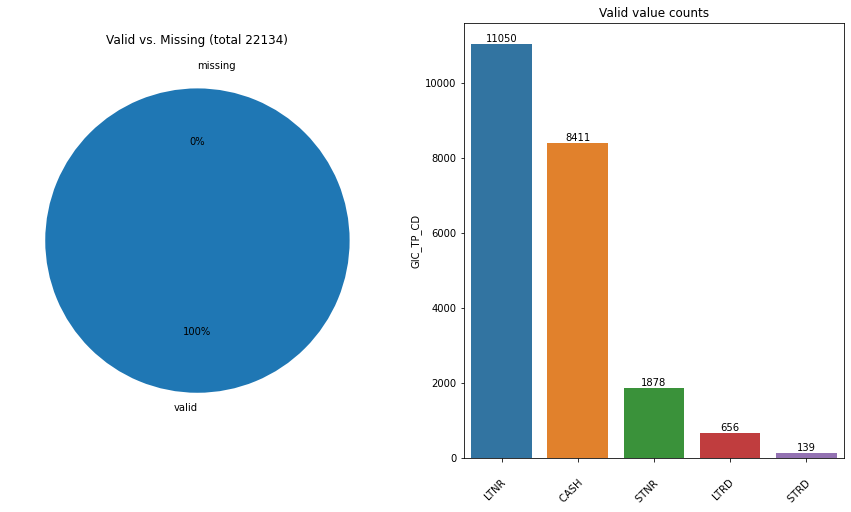

In [18]:
print(pdv.view_categ("GIC_TP_CD"))

CategCol([total/missing/rate] = [22134/17394/78.6%], categ lvls = 5)


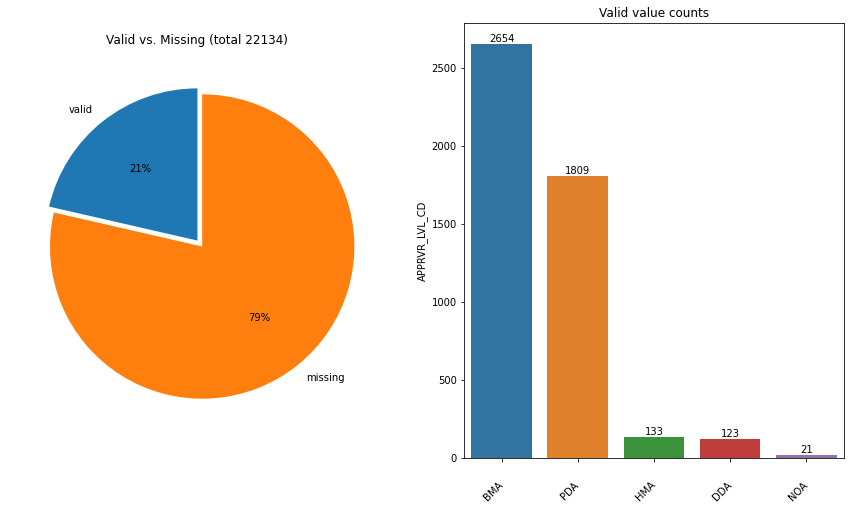

In [19]:
print(pdv.view_categ("APPRVR_LVL_CD"))

NumCol([total/missing/rate] = [22134/0/0.0%], normal_boundary = [3.124066244473539, 7.0888562394406165])
count    22134.000000
mean         5.072433
std          0.741567
min          2.698970
25%          4.610862
50%          5.013887
75%          5.602060
max          7.903090
Name: LOG_ISSU_AMT, dtype: float64


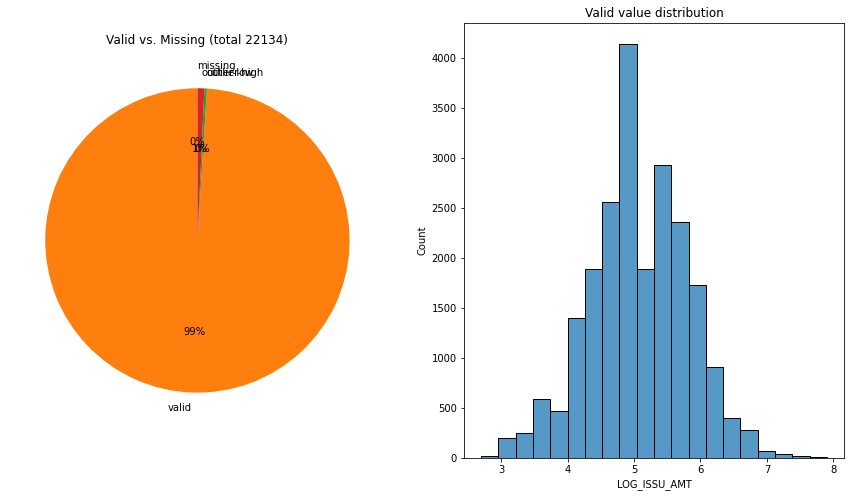

In [20]:
print(pdv.view_numeric("LOG_ISSU_AMT"))  # EDA on transformed column

## Part3. EDA for pyspark dataframe

In [21]:
from CommonTools.sparker import SparkConnector

SparkConnector.setup(jdbc_driver_folder = '/home/jovyan/work/jdbc_jars')

In [22]:
sc = SparkConnector(app_name = 'test_spark_EDA')

In [26]:
df_edl = sc.read_csv("/home/jovyan/work/edl-ftp.csv")
df_edl.createOrReplaceTempView("df_edl")
df_edl.show()

+----------+----------+-----------+
|        dt|productkey|    avg_bal|
+----------+----------+-----------+
|2021-07-31|      1522|    4976.52|
|2021-07-31|      1522|    1700.21|
|2021-07-31|      1505|   90519.61|
|2021-07-31|      1505|   35178.61|
|2021-07-31|      1522|    1121.19|
|2021-07-31|      1526|     800.81|
|2021-07-31|      1526|      837.1|
|2021-07-31|      1522|    3536.63|
|2021-07-31|      1531|   12395.79|
|2021-07-31|      1505|    1131.24|
|2021-07-31|      1505|     284.51|
|2021-07-31|      1510|    40000.0|
|2021-07-31|      1511|20187.19783|
|2021-07-31|      1510|    35000.0|
|2021-07-31|      1524|   21184.55|
|2021-07-31|      1522|    5663.89|
|2021-07-31|      1522|    2387.79|
|2021-07-31|      1531|   20441.21|
|2021-07-31|      1643|    6697.12|
|2021-07-31|      1644|   33775.59|
+----------+----------+-----------+
only showing top 20 rows



In [27]:
sql = """
select
    productkey,
    log10(avg_bal) as LOG_AVG_BAL
from
    df_edl
where
    avg_bal > 0 or avg_bal is null
"""
df_edl_etl = sc.spark.sql(sql)
df_edl_etl.show()

+----------+------------------+
|productkey|       LOG_AVG_BAL|
+----------+------------------+
|      1522| 3.696925753783134|
|      1522| 3.230502566206867|
|      1505| 4.956742674146889|
|      1505| 4.546278675335883|
|      1522| 3.049679215591828|
|      1526| 2.903529487695167|
|      1526|2.9227773419287977|
|      1522|3.5485896265765273|
|      1531| 4.093274210144389|
|      1505| 3.053554753129048|
|      1505|2.4540975356467136|
|      1510|4.6020599913279625|
|      1511| 4.305076039031426|
|      1510| 4.544068044350276|
|      1524|4.3260192431969315|
|      1522| 3.753114810208389|
|      1522| 3.377996129052153|
|      1531| 4.310506599915201|
|      1643|3.8258880807595212|
|      1644| 4.528602944119126|
+----------+------------------+
only showing top 20 rows



In [28]:
from ModelingTools.Explore.preview import SparkPreviewer

sp = SparkPreviewer(df_edl_etl)

CategCol([total/missing/rate] = [1449777/0/0.0%], categ lvls = 32)


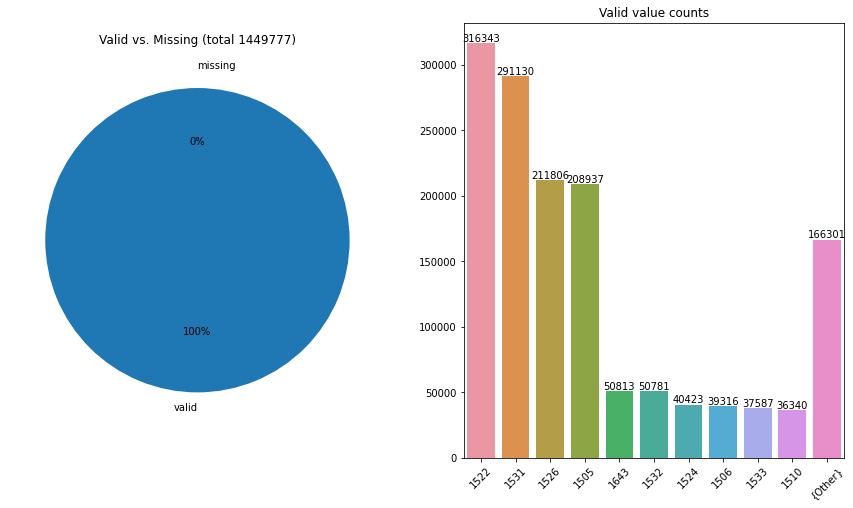

In [29]:
print(sp.view_categ("productkey"))

NumColSpark([total/missing/rate] = [1449777/0/0.0%], normal_boundary = [2.485620141029358, 5.615795731544495])
count                1449777
mean      4.0136709815680724
stddev    0.6476844687054653
min                     -2.0
25%                3.6595938
50%                4.0079784
75%                 4.441862
max                      8.0
Name: LOG_AVG_BAL, dtype: object


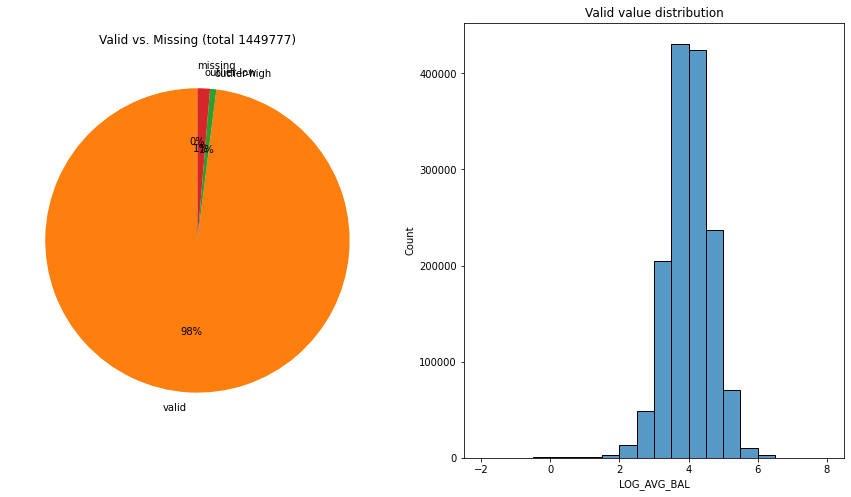

In [30]:
print(sp.view_numeric("LOG_AVG_BAL"))